# Train Static Gaussian

In [1]:
using AutomotiveDrivingModels

## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
nothing

In [3]:
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

"_following"

In [9]:
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

nframes = nrow(dset.dataframe)
ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [5]:
train_def = BehaviorTrainDefinition(SG_TrainParams())
preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
AutomotiveDrivingModels.SG_TrainParams()
hyperparams:


In [6]:
AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
                    train_def, dset, preallocated_data, cv_split_inner)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
AutomotiveDrivingModels.SG_TrainParams()
hyperparams:


## train

In [7]:
SG = train(dset, preallocated_data, train_def.trainparams, fold, cv_split_outer, true);
print(SG)

SG
	μ:
		[    0.001572,    -0.020409]
	Σ:
		[    0.000260,     0.000876]
		[    0.000876,     0.124162]


## likelihood

In [21]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nframes
    if trains_with_nona(SG)
        logl = calc_action_loglikelihood(SG, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(SG, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

println("extrema train: ", extrema(arr_logl_train))
println("extrema test:  ", extrema(arr_logl_test))

extrema train: (-614.9957665189808,3.3440342774846683)  2.263571888788591
extrema test:  (-11.984220956009057,3.3440350773983476)  2.7660926759588595


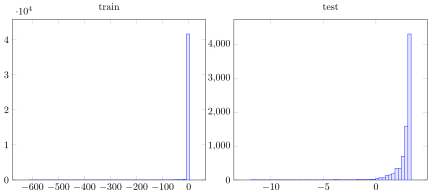

In [23]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

In [28]:
using Discretizers
disc = LinearDiscretizer(collect(linspace(extrema(arr_logl_train)..., 51)))
counts = zeros(Int, nlabels(disc))
for v in arr_logl_train
    counts[encode(disc, v)] += 1
end
println("counts train: ", counts)

counts train: [2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,11,3,0,2,9,54,62,55,195,41661]


In [31]:
disc = LinearDiscretizer(collect(linspace(extrema(arr_logl_test)..., 51)))
counts = zeros(Int, nlabels(disc))
for v in arr_logl_test
    counts[encode(disc, v)] += 1
end
println("counts train: ", counts)

counts train: [1,1,0,1,1,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,1,0,1,2,2,2,7,5,2,3,3,4,2,10,7,7,7,14,21,40,62,64,133,148,193,342,332,701,1592,4300]
